## Facial Filters

Using your trained facial keypoint detector, you can now do things like add filters to a person's face, automatically. In this optional notebook, you can play around with adding sunglasses to detected face's in an image by using the keypoints detected around a person's eyes. Checkout the `images/` directory to see what pther .png's have been provided for you to try, too!

<img src="images/face_filter_ex.png" width=60% height=60%/>

Let's start this process by looking at a sunglasses .png that we'll be working with!

In [1]:
# import necessary resources
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import cv2

Image shape:  (1123, 3064, 4)


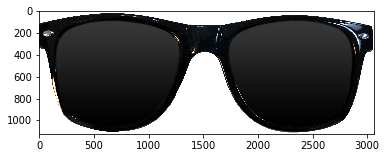

In [2]:
# load in sunglasses image with cv2 and IMREAD_UNCHANGED
sunglasses = cv2.imread('images/sunglasses.png', cv2.IMREAD_UNCHANGED)

# plot our image
plt.imshow(sunglasses)

# print out its dimensions
print('Image shape: ', sunglasses.shape)

## The 4th dimension

You'll note that this image actually has *4 color channels*, not just 3 as your avg RGB image does. This is due to the flag we set `cv2.IMREAD_UNCHANGED`, which tells this to read in another color channel.

#### Alpha channel
It has the usual red, blue, and green channels any color image has, and the 4th channel respresents the **transparency level of each pixel** in the image; this is often called the **alpha** channel. Here's how the transparency channel works: the lower the value, the more transparent, or see-through, the pixel will become.  The lower bound (completely transparent) is zero here, so any pixels set to 0 will not be seen; these look like white background pixels in the image above, but they are actually totally transparent. 

This transparent channel allows us to place this rectangular image of sunglasses on an image of a face and still see the face area that is techically covered by the transparentbackground of the sunglasses image!

Let's check out the alpha channel of our sunglasses image in the next Python cell. Because many of the pixels in the background of the image have an alpha value of 0, we'll need to explicitly print out non-zero values if we want to see them.

The alpha channel looks like this (black pixels = transparent): 


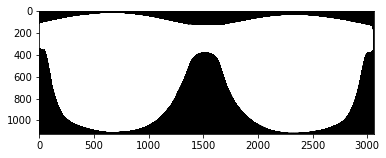

In [3]:
# print out the sunglasses transparency (alpha) channel
alpha_channel = sunglasses[:,:,3]
print ('The alpha channel looks like this (black pixels = transparent): ')
plt.imshow(alpha_channel, cmap='gray')

In [4]:
# just to double check that there are indeed non-zero values
# let's find and print out every value greater than zero
values = np.where(alpha_channel != 0)
print ('The non-zero values of the alpha channel are: ')
print (values)

The non-zero values of the alpha channel are: 
(array([  17,   17,   17, ..., 1109, 1109, 1109], dtype=int64), array([ 687,  688,  689, ..., 2376, 2377, 2378], dtype=int64))


#### Overlaying images

This means that when we place this sunglasses image on top of another image, we can use the transparency channel as a filter:

* If the pixels are non-transparent (alpha_channel > 0), overlay them on the new image

#### Keypoint locations

In doing this, it's helpful to understand which keypoint belongs to the eyes, mouth, etc., so in the image below we also print the index of each facial keypoint directly on the image so you can tell which keypoints are for the eyes, eyebrows, etc.,

<img src="images/landmarks_numbered.jpg" width=50% height=50%/>

It may be useful to use keypoints that correspond to the edges of the face to define the width of the sunglasses, and the locations of the eyes to define the placement.

Next, we'll load in an example image. Below, you've been given an image and set of keypoints from the provided training set of data, but you can use your own CNN model to generate keypoints for *any* image of a face (as in Notebook 3) and go through the same overlay process!

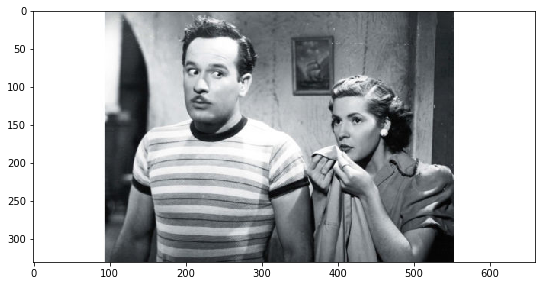

In [12]:
import cv2
# load in color image for face detection
image = cv2.imread('images/pepe.jpg')

# switch red and blue color channels 
# --> by default OpenCV assumes BLUE comes first, not RED as in many images
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# plot the image
fig = plt.figure(figsize=(9,9))
plt.imshow(image)

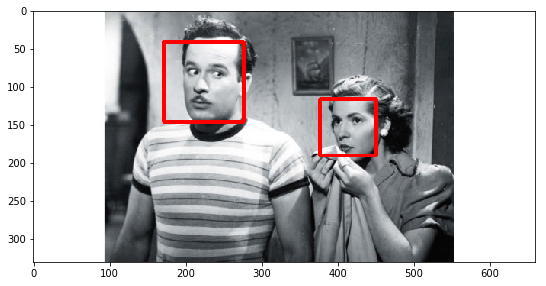

In [14]:
# load in a haar cascade classifier for detecting frontal faces
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

# run the detector
# the output here is an array of detections; the corners of each detection box
# if necessary, modify these parameters until you successfully identify every face in a given image
faces = face_cascade.detectMultiScale(image, 1.2, 2)

# make a copy of the original image to plot detections on
image_with_detections = image.copy()

# loop over the detected faces, mark the image where each face is found
for (x,y,w,h) in faces:
    # draw a rectangle around each detected face
    # you may also need to change the width of the rectangle drawn depending on image resolution
    cv2.rectangle(image_with_detections,(x,y),(x+w,y+h),(255,0,0),3) 

fig = plt.figure(figsize=(9,9))

plt.imshow(image_with_detections)

In [15]:
import torch
from models import Net

dropout_prob = 0.5
net = Net(dropout_prob)

state_dict = torch.load('saved_models/keypoints_model_400.pt')
#print(state_dict.keys())
net.load_state_dict(state_dict)

## TODO: load the best saved model parameters (by your path name)
## You'll need to un-comment the line below and add the correct name for *your* saved model
# net.load_state_dict(torch.load('saved_models/keypoints_model_1.pt'))

## print out your net and prepare it for testing (uncomment the line below)
net.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(7, 7), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=5000, bias=True)
  (drop5): Dropout(p=0.5)
  (fc2): Linear(in_features=5000, out_features=1024, bias=True)
  (drop6): Dropout(p=0.5)
  (fc3): Linear(in_features=1024, out_features=136, bias=True)
)

In [16]:
def visualize_output(faces, test_outputs):  
    batch_size = len(faces)
    for i, face in enumerate(faces):
        plt.figure(figsize=(8, 8))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100

        plt.imshow(face, cmap='gray')
        plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
        
        plt.axis('off')

    plt.show()

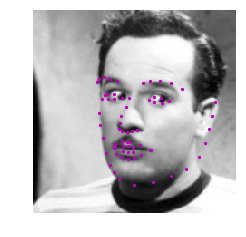

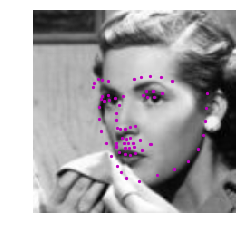

In [17]:
image_copy = np.copy(image)

# I am using the code of https://github.com/sunsided/facial-keypoints as a guide

images, keypoints = [], []
PADDING = 25

# loop over the detected faces from your haar cascade
for (x,y,w,h) in faces:
    
    # Select the region of interest that is the face in the image 
    roi = image_copy[y-PADDING:y+h+PADDING, x-PADDING:x+w+PADDING]
    
    ## TODO: Convert the face region from RGB to grayscale
    roi = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)

    ## TODO: Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
    roi = (roi / 255.).astype(np.float32)
    
    ## TODO: Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
    roi = cv2.resize(roi, (224, 224))
    images.append(roi)
    
    ## TODO: Reshape the numpy image shape (H x W x C) into a torch image shape (C x H x W)
    if len(roi.shape) == 2:
        roi = np.expand_dims(roi, axis=0)
    else:
        roi = np.rollaxis(roi, 2, 0)
    
    # Make it a batch of length 1
    # If you don't, this happens:
    roi = np.expand_dims(roi, axis=0)
    
    ## TODO: Make facial keypoint predictions using your loaded, trained network 
    ## wrap each face region in a Variable and perform a forward pass to get the predicted facial keypoints
    roi = torch.from_numpy(roi).type(torch.FloatTensor)
    results = net.forward(roi)
    
    results = results.view(results.size()[0], 68, -1).cpu()
    keypoints.append(results[0])
    
## TODO: Display each detected face and the corresponding keypoints
visualize_output(images, keypoints)

In [22]:
# load in training data
key_pts_frame = pd.read_csv('data/training_frames_keypoints.csv')

#print(key_pts_frame)

#print(keypoints)

# print out some stats about the data
print('Number of images: ', key_pts_frame.shape[0])

                               Unnamed: 0      0      1      2      3      4  \
0                       Luis_Fonsi_21.jpg   45.0   98.0   47.0  106.0   49.0   
1                   Lincoln_Chafee_52.jpg   41.0   83.0   43.0   91.0   45.0   
2                   Valerie_Harper_30.jpg   56.0   69.0   56.0   77.0   56.0   
3                     Angelo_Reyes_22.jpg   61.0   80.0   58.0   95.0   58.0   
4              Kristen_Breitweiser_11.jpg   58.0   94.0   58.0  104.0   60.0   
5                    Albert_Brooks_12.jpg   67.0  134.0   69.0  144.0   72.0   
6                 Daniel_Radcliffe_02.jpg   35.0   57.0   35.0   62.0   35.0   
7                      Laura_Bozzo_41.jpg   90.0   68.0   88.0   74.0   90.0   
8                      James_Hoffa_51.jpg   47.0  101.0   47.0  117.0   50.0   
9               Christopher_Walken_20.jpg  126.0  107.0  126.0  122.0  130.0   
10                   Paul_Otellini_01.jpg   31.0   74.0   31.0   81.0   33.0   
11                  Linda_Franklin_01.jp

In [60]:
# helper function to display keypoints
def show_keypoints(image, key_pts):
    """Show image with keypoints"""
    plt.imshow(image, cmap='gray')
    plt.scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='.', c='m')


Image name:  Christopher_Walken_01.jpg


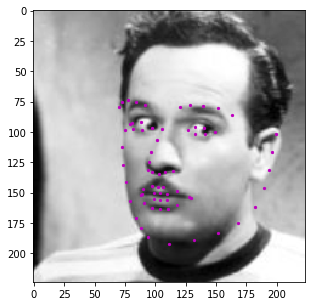

In [67]:
# a selected image
n = 120
image_name = key_pts_frame.iloc[n, 0]
image = mpimg.imread(os.path.join('data/training/', image_name))
key_pts = key_pts_frame.iloc[n, 1:].as_matrix()

key_pts = key_pts.astype('float').reshape(-1, 2)
kps = keypoints[0].detach().numpy()

# undo normalization of keypoints  
pred_kps = kps*50.0+100
#with torch.no_grad():
    #.var.detach().numpy()

#print(predicted_kps)
#print(key_pts)

img_pepe = images[0]

print('Image name: ', image_name)

plt.figure(figsize=(5, 5))
#show_keypoints(image, key_pts)
show_keypoints(images[0], pred_kps)

## TODO: Convert the face region from RGB to grayscale

mpimg.imsave('images/pepe_detected.png', images[0], cmap='gray', format="png")

plt.show()

Next, you'll see an example of placing sunglasses on the person in the loaded image.

Note that the keypoints are numbered off-by-one in the numbered image above, and so `key_pts[0,:]` corresponds to the first point (1) in the labelled image.

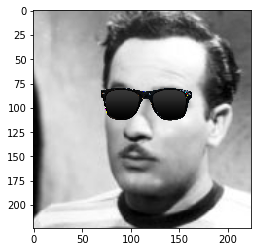

In [79]:
# Display sunglasses on top of the image in the appropriate place


# copy of the face image for overlay
#image_copy2 = np.copy(images[0])


image = mpimg.imread('images/pepe_detected.png')

image_copy = np.copy(image)

#print(image_copy)
#print(image_copy2)

#print(image_copy)
key_pts = pred_kps
#print(key_pts)

# top-left location for sunglasses to go
# 17 = edge of left eyebrow
x = int(key_pts[17, 0])
y = int(key_pts[17, 1])

# height and width of sunglasses
# h = length of nose
h = int(abs(key_pts[27,1] - key_pts[34,1]))
# w = left to right eyebrow edges
w = int(abs(key_pts[17,0] - key_pts[26,0]))

# read in sunglasses
sunglasses = cv2.imread('images/sunglasses.png', cv2.IMREAD_UNCHANGED)
# resize sunglasses
new_sunglasses =  cv2.resize(sunglasses, (w, h), interpolation = cv2.INTER_CUBIC)

#print(new_sunglasses)

# get region of interest on the face to change
roi_color = image_copy[y:y+h,x:x+w]

# find all non-transparent pts
ind = np.argwhere(new_sunglasses[:,:,3] > 0)

# for each non-transparent point, replace the original image pixel with that of the new_sunglasses
for i in range(3):
    roi_color[ind[:,0],ind[:,1],i] = 255-new_sunglasses[ind[:,0],ind[:,1],i]   
# set the area of the image to the changed region with sunglasses
image_copy[y:y+h,x:x+w] = roi_color


# display the result!
#plt.imshow(image, cmap='gray')
plt.imshow(image_copy, cmap='gray')

#### Further steps

Look in the `images/` directory to see other available .png's for overlay! Also, you may notice that the overlay of the sunglasses is not entirely perfect; you're encouraged to play around with the scale of the width and height of the glasses and investigate how to perform [image rotation](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_geometric_transformations/py_geometric_transformations.html) in OpenCV so as to match an overlay with any facial pose.